In [1]:
# Imports.
from g2p_client import G2PDatabase
from __future__ import division
import pandas as pd

import numpy as np
import sys
from itertools import product

import holoviews as hv
hv.extension('bokeh')
from bokeh.resources import INLINE
from bokeh.io import output_notebook
output_notebook(resources=INLINE)

ImportError: No module named hgvs.location

In [5]:
# Constants
INDEX = 'associations'
# HOST = 'g2p-ohsu.ddns.net'
HOST = 'dms-dev.compbio.ohsu.edu'
DATABASE = G2PDatabase(HOST, INDEX)
GENIE_VARIANTS = '../data/data_mutations_extended.txt'
occurence_thres = 2
evidence_levels = ['A', 'B', 'C', 'D']
evidence_directions = ['resistant', 'responsive']

In [3]:
# Put G2P into a dataframe because this is the fastest way to work with it.
g2p_df = DATABASE.hits_to_dataframe(DATABASE.query_all())
g2p_df.groupby('source').size()

INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/associations/_search?scroll=5m&size=1000 [status:200 request:0.892s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:0.972s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:1.001s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:0.902s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:0.378s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:0.305s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:0.207s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:0.207s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scrol

source
brca                      5733
cgi                       1431
civic                     3176
jax                       3649
jax_trials                1131
molecularmatch            2079
molecularmatch_trials    41143
oncokb                    4149
pmkb                       609
sage                        69
dtype: int64

In [15]:
cgi_tumor_types = {}
for i, row in g2p_df.iterrows():
    if row['cgi_phenotype'] != '' and row['phenotype'] not in cgi_tumor_types:
        cgi_tumor_types[row['phenotype']] = row['cgi_phenotype']
        
for i, row in g2p_df.iterrows():
    if (row['cgi_phenotype'] == '' or row['cgi_phenotype'] == None) and row['phenotype'] in cgi_tumor_types:
        g2p_df.set_value(i, 'cgi_phenotype', cgi_tumor_types[row['phenotype']])
        
g2p_df.head(100)

,source,genes,drug,phenotype,cgi_phenotype,feature_geneSymbol,feature_name,feature_entrez_id,feature_chromosome,feature_start,...,feature_ref,feature_alt,feature_referenceName,feature_biomarker_type,feature_description,description,evidence_label,evidence_direction,evidence_url,oncogenic
0,jax,"SMAD4,CDKN2A,FGFR1",CRIZOTINIB,pancreatic ductal adenocarcinoma,,ALK,EML4-ALK,,,,...,,,,fusion,,"In a clinical case study, a pancreatic ductal ...",C,resistant,http://www.ncbi.nlm.nih.gov/pubmed/28476735,
1,civic,ALK,CRIZOTINIB,non-small cell lung carcinoma,NSCLC,ALK,EML4-ALK S1206Y,238,2,29443600,...,G,T,GRCh37,snp,,"In an in vitro study, a Ba/F3 cell line expres...",D,resistant,[http://www.ncbi.nlm.nih.gov/pubmed/24675041],
2,civic,VHL,VEGF,renal cell carcinoma,,VHL,LOSS,7428,3,10182692,...,None,None,GRCh37,loss of function,,A meta-analysis to evaluate the association be...,B,resistant,[http://www.ncbi.nlm.nih.gov/pubmed/28103578],
3,jax,AKT1,AZD5363,ovarian endometrial cancer,,AKT1,AKT1 E17K,,14,105246551,...,C,T,GRCh37,mutant,,"In a Phase I clinical study, a patient with en...",C,sensitive,http://www.ncbi.nlm.nih.gov/pubmed/26351323,
4,civic,VHL,,von Hippel-Lindau disease,,VHL,F119L (c.357C>G),7428,None,None,...,None,None,None,,,"In a study of 114 unrelated VHL families, 85 g...",C,Likely Pathogenic,[http://www.ncbi.nlm.nih.gov/pubmed/7728151],
5,jax,"CDKN2A,NRAS","PALBOCICLIB,TRAMETINIB",melanoma,,CDKN2A,CDKN2A loss,,9,21974726,...,G,A,GRCh37,loss,,"In a preclinical study, the combination of Ibr...",D,sensitive,http://www.ncbi.nlm.nih.gov/pubmed/22983396,
6,civic,ALK,CERITINIB,non-small cell lung carcinoma,NSCLC,ALK,EML4-ALK S1206Y,238,2,29443600,...,G,T,GRCh37,snp,,In a prospective study (NCT01283516) of 130 ca...,C,Sensitivity,[http://www.ncbi.nlm.nih.gov/pubmed/24670165],
7,jax,"NRAS,BRAF",878739-06-1,melanoma,,NRAS,NRAS G12D,,1,115258747,...,C,T,GRCh37,mutant,,"In a preclinical study, AZ628 inhibited prolif...",D,sensitive,http://www.ncbi.nlm.nih.gov/pubmed/27523909,
8,civic,ALK,,renal cell carcinoma,,ALK,EML4-ALK E2;A20,238,2,42396490,...,None,None,GRCh37,fusion,,Adenocarcinoma cells were detected via urinary...,D,Sensitivity,[http://www.ncbi.nlm.nih.gov/pubmed/22252991],
9,civic,VHL,,von Hippel-Lindau disease,,VHL,F76del (c.226_228delTTC),7428,None,None,...,None,None,None,,,Germline mutations were found in all 93 famili...,C,Uncertain Significance,[http://www.ncbi.nlm.nih.gov/pubmed/9829911],


In [35]:
def get_num_donors(df):
    ''' Returns number of donors in a dataframe. '''
    return len(df['Tumor_Sample_Barcode'].unique())
    

def print_cohort_stats(df):
    print '-------------'
    print 'Number of variants: %i' % len(df)
    #print 'Number of unique variants: %i' % len(df[df['count'] > 1])
    print 'Number of donors: %i' % get_num_donors(df)
    print '-------------'

# Load GENIE variants.
genie_variants = pd.read_csv(GENIE_VARIANTS, sep='\t', comment='#')

print "All of GENIE"
print_cohort_stats(genie_variants)

# Count occurences for each variant and add a 'count' column.
variant_counts = genie_variants.groupby(['Chromosome', 'Start_Position', 'End_Position', 'Reference_Allele', 'Tumor_Seq_Allele2']).size().rename('count').reset_index()
genie_variants = pd.merge(genie_variants, variant_counts, on=['Chromosome', 'Start_Position', 'End_Position', 'Reference_Allele', 'Tumor_Seq_Allele2'])

print ''
print "GENIE filtered for variant count >= %i" % occurence_thres
print_cohort_stats(genie_variants[genie_variants['count'] >= occurence_thres])

# For later use:
num_variants = len(genie_variants)
num_donors = get_num_donors(genie_variants)
shared_variants = genie_variants[genie_variants['count'] >= occurence_thres]
num_shared_variants = len(shared_variants)
num_donors_with_shared_variants = get_num_donors(shared_variants)

All of GENIE
-------------
Number of variants: 110320
Number of donors: 17005
-------------

GENIE filtered for variant count >= 2
-------------
Number of variants: 40246
Number of donors: 14813
-------------


In [36]:
%%opts Bars [width=600]

# Look at distribution of variants across donors.
# NOTE: most donors have only 1 variant.
def histogram(dataframe, col, bins=50):
    hist, edges = np.histogram(dataframe.groupby([col]).size(), bins=bins)
    print hist
    print edges
    
    return hv.Bars((edges[0:-1], hist), kdims='x', vdims='y')
    
histogram(genie_variants, 'Tumor_Sample_Barcode', bins=range(1, 40))

[2963 2698 2276 1853 1495 1255  990  698  538  372  272  211  143  138  103
   80   62   54   63   56   44   41   32   24   23   20   20   21   23   22
    9   10   15    9   15   19   15   26]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


:Bars   [x]   (y)

In [7]:
# Group variants by source, evidence_label, and evidence_direction.
grouped_evidence_df = g2p_df.groupby(['feature_chromosome', 'feature_start', 'feature_ref', 'feature_alt', 'source', 'evidence_label']).size().rename('evidence_count').reset_index()
print "Raw number of mutations in G2P:", len(grouped_evidence_df)

grouped_evidence_with_gene_df = g2p_df.groupby(['feature_chromosome', 'feature_start', 'feature_ref', 'feature_alt', 'source', 'evidence_label', 'feature_geneSymbol']).size().rename('evidence_count').reset_index()
print "Raw number of mutations in G2P (including gene):", len(grouped_evidence_with_gene_df)

# Remove entries without chromosome, start, ref, alt.
grouped_evidence_df = grouped_evidence_df[~(grouped_evidence_df['feature_chromosome']).isin(['','None']) & \
                                          ~(grouped_evidence_df['feature_start']).isin(['','None']) & \
                                          ~(grouped_evidence_df['feature_ref']).isin(['','None']) & \
                                          ~(grouped_evidence_df['feature_alt']).isin(['','None'])]
print "Number of complete mutations in G2P:", len(grouped_evidence_df)
sources = list(grouped_evidence_df['source'].unique())
print "Sources with viable mutations (%i):" % len(sources), ', '.join(sources)

# Remove entries without chromosome, start, ref, alt. (for df including gene)
grouped_evidence_with_gene_df = grouped_evidence_with_gene_df[~(grouped_evidence_with_gene_df['feature_chromosome']).isin(['','None']) & \
                                          ~(grouped_evidence_with_gene_df['feature_start']).isin(['','None']) & \
                                          ~(grouped_evidence_with_gene_df['feature_ref']).isin(['','None']) & \
                                          ~(grouped_evidence_with_gene_df['feature_alt']).isin(['','None'])]
print "Number of complete mutations in G2P (including gene):", len(grouped_evidence_with_gene_df)
sources = list(grouped_evidence_with_gene_df['source'].unique())
print "Sources with viable mutations (%i) (including gene):" % len(sources), ', '.join(sources)

# Create dataframe with single row per variant and evidence counts 
# as columns (e.g. 'civic_A' for evidence counts from CIVIC at level A).
new_data = []
for (chrom, start, ref, alt), df in grouped_evidence_df.groupby(['feature_chromosome', 'feature_start', 'feature_ref', 'feature_alt']):
    # Create base dictionary with all needed keys.
    d = {
        'chrom': chrom,
        'start': start,
        'ref': ref,
        'alt': alt,
    }
    keys = ['%s_%s' % (source, evidence_label) \
            for (source, evidence_label) in product(sources, evidence_levels)]
    d.update(dict.fromkeys(keys, 0))
    
    # Update entries based on evidence counts.
    for i, row in df.iterrows():
        d['%s_%s' % (row['source'], row['evidence_label'])] = row['evidence_count']
    new_data.append(d)
variant_ev_counts_df = pd.DataFrame(new_data).fillna(0)
variant_ev_counts_df = variant_ev_counts_df[['chrom', 'start', 'ref', 'alt'] + keys]
variant_ev_counts_df.head(100)

# Compute totals.

# Compute totals for source.
for source in sources:
    variant_ev_counts_df['total_source_%s' % (source)] = variant_ev_counts_df.filter(regex='^%s_' % (source)).sum(axis=1)

# Compute totals for levels.
for level in evidence_levels:
    variant_ev_counts_df['total_%s' % (level)] = variant_ev_counts_df.filter(regex='_%s$' % (level)).sum(axis=1)

# Compute totals for all using sources.
variant_ev_counts_df['total_source_total'] = variant_ev_counts_df.filter(regex='^total_source').sum(axis=1)
sources = sources + ['total']

pd.options.display.max_columns = None
variant_ev_counts_df.head()
grouped_evidence_with_gene_df.head()

Raw number of mutations in G2P: 3005
Raw number of mutations in G2P (including gene): 4254
Number of complete mutations in G2P: 2316
Sources with viable mutations (8): civic, cgi, oncokb, molecularmatch, jax, molecularmatch_trials, jax_trials, pmkb
Number of complete mutations in G2P (including gene): 2320
Sources with viable mutations (8) (including gene): civic, cgi, oncokb, molecularmatch, jax, molecularmatch_trials, jax_trials, pmkb


,feature_chromosome,feature_start,feature_ref,feature_alt,source,evidence_label,feature_geneSymbol,evidence_count
1265,1,8073509,C,A,civic,C,ERRFI1,1
1268,1,11169361,C,G,cgi,D,MTOR,1
1269,1,11174420,C,T,cgi,C,MTOR,1
1271,1,11177096,C,A,civic,D,MTOR,3
1272,1,11182158,A,C,oncokb,D,MTOR,1


In [8]:
# Annotate GENIE variants with evidence counts.
annotated_genie_variants = pd.merge(genie_variants, variant_ev_counts_df, how='left',
             left_on=['Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2'],
             right_on=['chrom', 'start', 'ref', 'alt']).fillna(0)
shared_annotated_genie_variants = annotated_genie_variants[annotated_genie_variants['count'] >= occurence_thres]

In [9]:
%%opts Bars [title_format="GENIE non-unique variant coverage" xrotation=90, height=600 width=600]
%%opts Bars (color=Cycle('Spectral'))

# Print bar chart showing variant coverage of each source + total.
results_df = shared_annotated_genie_variants
data = [(source, 
         len(results_df[results_df['total_source_%s' % source] > 0]) / num_shared_variants * 100) \
         for source in sources]
data.sort(key=lambda tup: tup[1])
hv.Bars(data, kdims=[hv.Dimension('Source')], vdims=['Percent'])

:Bars   [Source]   (Percent)

In [10]:
%%opts Bars.Grouped [group_index=1 title_format="GENIE non-unique variant coverage by evidence level" height=600 width=600 legend_position='top']
%%opts Bars (color=Cycle('Spectral'))
# %%opts Bars.Stacked [stack_index=1 title_format="GENIE non-unique variant coverage by evidence level" height=600 width=600 legend_position='top' xrotation=90 ]

# Print grouped bar chart showing variant coverage by source, evidence level.
results_df = shared_annotated_genie_variants
data = []
for (source, evidence_level) in product(sources, evidence_levels):
    source_el_counts = results_df.filter(regex='^%s_%s' % (source, evidence_level)).sum(axis=1)
    num_found = len(source_el_counts[source_el_counts > 0])/num_shared_variants * 100
    data.append( (source, evidence_level) + (num_found,) )
    
el_bars = hv.Bars(data, kdims=['Source', 'Evidence Level'], vdims=['Percent'])
el_bars.relabel(group='Grouped')
# el_bars.relabel(group='Stacked')

:Bars   [Source,Evidence Level]   (Percent)

In [10]:
%%opts Bars.Grouped [group_index=1 title_format="GENIE donor coverage by evidence level" height=600 width=600 legend_position='top']
%%opts Bars (color=Cycle('Spectral'))
# %%opts Bars.Stacked [stack_index=1 title_format="GENIE donor coverage by evidence level" height=600 width=600 legend_position='top' xrotation=90 ]

# Print grouped bar chart showing donor coverage by source, evidence level.
results_df = shared_annotated_genie_variants
data = []
for (source, evidence_level) in product(sources, evidence_levels):
    variants = results_df[(results_df['%s_%s' % (source, evidence_level)] > 0)]
    donor_percent = get_num_donors(variants) / num_donors * 100
    data.append( (source, evidence_level) + (donor_percent,) )

el_bars = hv.Bars(data, kdims=['Source', 'Evidence Level'], vdims=['Percent'])
el_bars.relabel(group='Grouped')
# el_bars.relabel(group='Stacked')

:Bars   [Source,Evidence Level]   (Percent)

In [11]:
%%opts Bars.Grouped [group_index=1 title_format='GENIE coverage' height=600 width=600 legend_position='top']
%%opts Bars (color=Cycle('Category20') )
# %%opts Bars.Stacked [stack_index=1 title_format='GENIE coverage' height=600 width=600 legend_position='top' xrotation=90 ]

results_df = annotated_genie_variants

# Print bar chart with coverage by source + total.
data = []
for source in sources:
    variants_with_evidence = results_df[results_df['total_source_%s' % source] > 0]
    data.append( (source, 'All variants', len(variants_with_evidence)/num_variants * 100) )
    shared_variants_with_evidence = results_df[(results_df['total_source_%s' % source] > 0) & (results_df['count'] > 2)]
    data.append( (source, 'Non-unique variants', len(shared_variants_with_evidence)/num_shared_variants * 100) )
    data.append( (source, 'Donors', get_num_donors(variants_with_evidence)/num_donors * 100) )
    data.append( (source, 'Donors with non-unique variants', get_num_donors(shared_variants_with_evidence)/num_donors_with_shared_variants * 100) )
    
bars = hv.Bars(data, kdims=['Source', 'Metric'], vdims=['Percent'])
bars.relabel(group='Grouped')
# bars.relabel(group='Stacked')

:Bars   [Source,Metric]   (Percent)

In [13]:
# Are there variants in g2p which do not appear in GENIE?

# All g2p variants
grouped_evidence_df = g2p_df.groupby(['feature_chromosome', 'feature_start', 'feature_ref', 'feature_alt', 'source', 'evidence_label']).size().rename('evidence_count').reset_index()
grouped_evidence_with_gene_df = g2p_df.groupby(['feature_chromosome', 'feature_start', 'feature_ref', 'feature_alt', 'source', 'evidence_label', 'feature_geneSymbol']).size().rename('evidence_count').reset_index()

# g2p variants with genomic locus
grouped_evidence_df = grouped_evidence_df[~(grouped_evidence_df['feature_chromosome']).isin(['','None']) & \
                                          ~(grouped_evidence_df['feature_start']).isin(['','None']) & \
                                          ~(grouped_evidence_df['feature_ref']).isin(['','None']) & \
                                          ~(grouped_evidence_df['feature_alt']).isin(['','None'])]

# Remove entries without chromosome, start, ref, alt. (for df including gene)
grouped_evidence_with_gene_df = grouped_evidence_with_gene_df[~(grouped_evidence_with_gene_df['feature_chromosome']).isin(['','None']) & \
                                          ~(grouped_evidence_with_gene_df['feature_start']).isin(['','None']) & \
                                          ~(grouped_evidence_with_gene_df['feature_ref']).isin(['','None']) & \
                                          ~(grouped_evidence_with_gene_df['feature_alt']).isin(['','None'])]

# annotated_g2p_variants = pd.merge(grouped_evidence_df, genie_variants, how='left',
#              left_on=['feature_chromosome', 'feature_start', 'feature_ref', 'feature_alt'],
#              right_on=['Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2']).fillna(0)

annotated_g2p_variants = pd.merge(grouped_evidence_with_gene_df, genie_variants, how='left',
             left_on=['feature_chromosome', 'feature_start', 'feature_ref', 'feature_alt'],
             right_on=['Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2']).fillna(0)

g2p_not_genie = annotated_g2p_variants[annotated_g2p_variants['Start_Position'].isin([0, '', 'None'])].reset_index()

# Number of variants in g2p that is not in GENIE
print 'Number of variants in g2p: %i' % len(grouped_evidence_with_gene_df)
print 'Number of variants in g2p that are not in GENIE: %i' % len(g2p_not_genie)

pd.options.display.max_columns = None
g2p_not_genie.head()

Number of variants in g2p: 2320
Number of variants in g2p that are not in GENIE: 1235


,index,feature_chromosome,feature_start,feature_ref,feature_alt,source,evidence_label,feature_geneSymbol,evidence_count,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,Tumor_Sample_UUID,Matched_Norm_Sample_UUID,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,Exon_Number,t_depth,t_ref_count,t_alt_count,n_depth,n_ref_count,n_alt_count,all_effects,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,STRAND_VEP,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,RefSeq,SIFT,PolyPhen,EXON,INTRON,DOMAINS,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EAS_MAF,EUR_MAF,SAS_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,IMPACT,PICK,VARIANT_CLASS,TSL,HGVS_OFFSET,PHENO,MINIMISED,ExAC_AF,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,GENE_PHENO,FILTER,flanking_bps,variant_id,variant_qual,ExAC_AF_Adj,ExAC_AC_AN_Adj,ExAC_AC_AN,ExAC_AC_AN_AFR,ExAC_AC_AN_AMR,ExAC_AC_AN_EAS,ExAC_AC_AN_FIN,ExAC_AC_AN_NFE,ExAC_AC_AN_OTH,ExAC_AC_AN_SAS,ExAC_FILTER,count
0,0,1,8073509,C,A,civic,C,ERRFI1,1,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0
1,2,1,11174420,C,T,cgi,C,MTOR,1,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0
2,22,1,11184580,G,A,civic,D,MTOR,1,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0
3,23,1,11187094,G,T,civic,C,MTOR,1,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0
4,24,1,11187094,G,T,civic,D,MTOR,1,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0


In [13]:
# Which sources have variants not in GENIE?
sources_variants_not_genie = g2p_not_genie.groupby(['source']).size().rename('count').reset_index()
sources_variants_not_genie.head()

,source,count
0,cgi,229
1,civic,199
2,jax,267
3,molecularmatch,394
4,oncokb,33


In [14]:
# Which genes have variants not in GENIE? What's the percentage? 

genes_w_variants_not_genie = g2p_not_genie.groupby(['feature_geneSymbol']).size().rename('count').reset_index()
print "Number of genes with variants in g2p and not in GENIE: (%i)" % len(genes_w_variants_not_genie)
total_genes_g2p = g2p_df.groupby('feature_geneSymbol').size().rename('count').reset_index()
print "Total number of genes with variants in g2p: (%i)" % len(total_genes_g2p)
genes_w_variants_not_genie.head()



Number of genes with variants in g2p and not in GENIE: (130)
Total number of genes with variants in g2p: (974)


,feature_geneSymbol,count
0,,20
1,ABCB1,3
2,ABCG2,1
3,ABL1,136
4,AKT1,8


In [15]:
%%opts Bars [title_format="Genes with Variants present in G2P and not in GENIE" xrotation=90, height=600 width=900]
%%opts Bars (color=Cycle('Spectral'))

make_small = genes_w_variants_not_genie[~(genes_w_variants_not_genie['count'] <= 2)]

# Print bar chart showing variant coverage of each source + total.
data = [(row['feature_geneSymbol'], row['count']) \
         for index, row in make_small.iterrows()]

hv.Bars(data, kdims=[hv.Dimension('Genes with more than one variant in G2P and not GENIE')], vdims=['Number of Variants in G2P and not GENIE'])

:Bars   [Genes with more than one variant in G2P and not GENIE]   (Number of Variants in G2P and not GENIE)

In [15]:
%%opts Bars [title_format="Genes with Variants present in G2P and not in GENIE as Percentage" xrotation=90, height=600 width=900]
%%opts Bars (color=Cycle('Spectral'))

df=pd.DataFrame([['total', len(g2p_not_genie)]], columns=['feature_geneSymbol', 'count'])
print df
genes_w_variants_not_genie_with_total = genes_w_variants_not_genie.append(df, ignore_index=True)

make_small = genes_w_variants_not_genie_with_total[~(genes_w_variants_not_genie_with_total['count'] <= 2)]

# Print bar chart showing variant coverage of each source + total.
data = [(row['feature_geneSymbol'], row['count'] / len(g2p_not_genie) * 100) \
         for index, row in make_small.iterrows()]

hv.Bars(data, kdims=[hv.Dimension('Genes with more than one variant in G2P and not GENIE')], vdims=['Percent Variants in G2P and not GENIE'])

  feature_geneSymbol  count
0              total   1235


:Bars   [Genes with more than one variant in G2P and not GENIE]   (Percent Variants in G2P and not GENIE)

In [16]:
# Oncogenic Variants (Such as from Oncokb)



In [16]:
g2p_df.groupby('source').size()

g2p_biomarkers = g2p_df.groupby(['feature_biomarker_type']).size().rename('count').reset_index()
biomarkers = list(g2p_biomarkers['feature_biomarker_type'].unique())
print "Biomarker types (%i):" % len(biomarkers), ', '.join(biomarkers)

g2p_oncokb = g2p_df[g2p_df['source'].isin(['oncokb'])]
g2p_oncokb.head()
g2p_biomarkers.head()

Biomarker types (71): , 3 Prime UTR, 5 prime utr variant, 5'UTR, amplification, biallelic inactivation, copy number change, decreased expression, deletion, exon, feature truncation, feature_truncation, frameshift, fusion, fusion,snp, gain of function,snp, indel, inframe variant, insertion, insertion,snp, intervening sequence, intron, loss, loss of function, loss of heterozygosity, microsatellite, missense, mutant, mutant,gain of function, mutant,nonsense, negative, nonsense, nonsense,deletion, nonsense,insertion, nonsense,snp, nonsense,splice, over expression, polymorphic sequence variant, polymorphism, polymorphism,nonsense, polymorphism,nonsense,deletion, polymorphism,nonsense,insertion, polymorphism,nonsense,snp, polymorphism,snp, polymorphism,splice, positive, rearrangement, regulatory region variant, short tandem repeat variation, silent, snp, snp,nonsense,insertion, snp,nonsense,splice, snp,polymorphism,nonsense,deletion, snp,polymorphism,nonsense,insertion, splice, splice donor 

,feature_biomarker_type,count
0,,33047
1,3 Prime UTR,5
2,5 prime utr variant,2
3,5'UTR,2
4,amplification,496


In [49]:
## CGI Application

# Reload GENIE variants.

genie_variants = pd.read_csv(GENIE_VARIANTS, sep='\t', comment='#')

variant_counts = genie_variants.groupby(['Chromosome', 'Start_Position', 'End_Position', 'Reference_Allele', 'Tumor_Seq_Allele2']).size().rename('count').reset_index()
genie_variants = pd.merge(genie_variants, variant_counts, on=['Chromosome', 'Start_Position', 'End_Position', 'Reference_Allele', 'Tumor_Seq_Allele2'])

# Group variants by source, evidence_label, and evidence_direction.
grouped_evidence_df = g2p_df.groupby(['feature_chromosome', 'feature_start', 'feature_ref', 'feature_alt', 'source', 'phenotype', 'cgi_phenotype', 'evidence_label', 'evidence_direction']).size().rename('evidence_count').reset_index()
print "Raw number of mutations in G2P:", len(grouped_evidence_df)

# Remove entries without chromosome, start, ref, alt, phenotype.
grouped_evidence_df = grouped_evidence_df[~(grouped_evidence_df['feature_chromosome']).isin(['','None']) & \
                                          ~(grouped_evidence_df['feature_start']).isin(['','None']) & \
                                          ~(grouped_evidence_df['feature_ref']).isin(['','None']) & \
                                          ~(grouped_evidence_df['feature_alt']).isin(['','None']) & \
                                          ~(grouped_evidence_df['phenotype']).isin(['','None'])]

sources = list(grouped_evidence_df['source'].unique())

Raw number of mutations in G2P: 6297


,Variant_Classification,Variant_Type
0,Frame_Shift_Del,DEL
1,Missense_Mutation,SNP
2,Missense_Mutation,SNP
3,Missense_Mutation,SNP
4,Missense_Mutation,SNP
5,Missense_Mutation,SNP
6,Missense_Mutation,SNP
7,Missense_Mutation,SNP
8,Missense_Mutation,SNP
9,Missense_Mutation,SNP


In [30]:
## CGI Application


cgi_cancers = ['RA', 'SCHW', 'BLCA', 'PAAD', 'GBM', 'MA', 'COREAD', 'OV', 'RCCC', 'CM', 'LIP', \
               'G', 'UCEC', 'SOLID', 'BRCA', 'AML', 'LUAD', 'SCC', 'BCC', 'GIST', 'HNSC', 'HCL', \
               'CER', 'FRS', 'MESO', 'LUSC', 'BT', 'THCA', 'CH', 'L', 'NSCLC', 'LK', 'DLBCL', 'THYM', \
               'ESCA', 'HNC', 'STAD', 'PA', 'ALL', 'SK', 'RPC', 'MEN', 'R',  'UVM', 'CTCL', 'PRAD', \
               'AS', 'LY', 'HSEC', 'SCLC', 'ES', 'MERC', 'MM', 'HC', 'MPN', 'THF', 'S', 'NHLY', 'HLY', \
               'CML', 'T', 'B', 'RHBDS', 'MDS', 'CLL', 'DFS', 'WT', 'M', 'UG']

cgi_cancers_dict = {'acute lymphoid leukemia': 'ALL',
               'acute lymphocytic leukemia': 'ALL',
               'acute myeloid leukemia': 'AML', 
               'angiosarcoma': 'AS', 
               'brain cancer': 'B', 
               'brain glioma': 'B',
               'basal cell carcinoma': 'BCC', 
               'bladder carcinoma': 'BLCA', 
               'breast carcinoma': 'BRCA', 
               'breast cancer': 'BRCA', 
               'biliary tract cancer': 'BT',
               'biliary tract neoplasm': 'BT',
               'cervix cancer': 'CER', 
               'cholangiocarcinoma': 'CH', 
               'chronic lymphocytic leukemia': 'CLL', 
               'cutaneous melanoma': 'CM', 
               'chronic myelogenous leukemia': 'CML', 
               'colorectal adenocarcinoma': 'COREAD', 
               'cutaneous t-cell lymphoma': 'CTCL', 
               'dermatofibrosarcoma': 'DFS', 
               'diffuse large b cell lymphoma': 'DLBCL', 
               'diffuse large b-cell lymphoma': 'DLBCL',
               'endocrine system cancer': 'ES', 
               'esophageal carcinoma': 'ESCA', 
               'female reproductory system cancer': 'FRS',  
               'glioma': 'G', 
               'glioblastoma multiforme': 'GBM', 
               'gastrointestinal stromal cancer': 'GIST', 
               'hepatic carcinoma': 'HC', 
               'hairy-cell leukemia': 'HCL', 
               'hodking lymphoma': 'HLY', 
               'head and neck cancer': 'HNC',
               'head and neck carcinoma': 'HNC',
               'head and neck squamous cell carcinoma': 'HNSC', 
               'erdheim-chester histiocytosis': 'HSEC',
               'non-small cell lung carcinoma' : 'L',
               'lung cancer': 'L', 
               'liposarcoma': 'LIP', 
               'leukemia': 'LK', 
               'lung adenocarcinoma': 'LUAD', 
               'lung squamous cell carcinoma': 'LUSC', 
               'lymphoma': 'LY', 
               'melanoma': 'M', 
               'malignant astrocitoma': 'MA', 
               'myelodisplasic syndrome': 'MDS', 
               'meningioma': 'MEN', 
               'merkel cell carcinoma': 'MERC', 
               'mesothelioma': 'MESO', 
               'multiple myeloma': 'MM', 
               'malignant peripheral nerve sheat tumor': 'MPN', 
               'non-hodking lymphoma': 'NHLY', 
               'non small cell lung carcinoma': 'NSCLC', 
               'serous ovarian adenocarcinoma': 'OV',
               'ovarian cancer': 'OV',
               'pilocytic astrocytoma': 'PA', 
               'pancreas adenocarcinoma': 'PAAD', 
               'pancreatic carcinoma': 'PAAD',
               'pancreatic cancer': 'PAAD',
               'prostate adenocarcinoma': 'PRAD', 
               'prostate cancer': 'PRAD',
               'prostate cancer': 'PRAD',
               'UNKNOWN': 'R', 
               'renal angiomyolipoma': 'RA',
               'kidney angiomyolipoma': 'RA',
               'renal clear cell carcinoma': 'RCCC', 
               'rhabdomyosarcoma': 'RHBDS', 
               'renal papillary cell': 'RPC', 
               'sarcoma': 'S', 
               'squamous cell carcinoma': 'SCC', 
               'schwannoma': 'SCHW', 
               'small cell lung carcinoma': 'SCLC', 
               'lung small cell carcinoma': 'SCLC',
               'skin cancer': 'SK', 
               'skin melanoma': 'SK',
               'solid tumor': 'SOLID', 
               'stomach adenocarcinoma': 'STAD', 
               'testis cancer': 'T', 
               'thyroid cancer': 'THCA',
               'thyroid': 'THCA',
               'thyroid follicular': 'THF', 
               'thymic cancer': 'THYM', 
               'uterine corpus endometrioid carcinoma': 'UCEC', 
               'urogenital cancer-related': 'UG', 
               'uveal melanoma': 'UVM', 
               'wilms tumor': 'WT'} 

for i, row in grouped_evidence_df.iterrows():
    if row['cgi_phenotype'] == '' or row['cgi_phenotype'] == None:
        for key in cgi_cancers_dict.keys():
            p = str(row['phenotype'].lower())
            if p != 'cancer' and p in key:
                grouped_evidence_df.set_value(i, 'cgi_phenotype', cgi_cancers_dict[key])
                
#for index, row in grouped_evidence_df.iterrows():
#    for key in cgi_cancers_dict.keys():
#        p = str(row[5].lower())
#        if p != 'cancer' and p in key:
#            grouped_evidence_df.loc[index, 'cgi_phenotype'] = cgi_cancers_dict[key]

direction_dict = {'sensitivity': 'sensitive',
                  'sensitive': 'sensitive',
                  'better outcome': 'sensitive',
                  'responsive': 'sensitive',
                  'resistance': 'resistant',
                  'resistant': 'resistant',
                  'increased toxicity': 'resistant',
                  'adverse response': 'resistant'}

for index, row in grouped_evidence_df.iterrows():
    for key in direction_dict.keys():
        p = str(row['evidence_direction'].lower())
        if p in key:
            grouped_evidence_df.loc[index, 'cgi_direction'] = direction_dict[key]          

grouped_evidence_df = grouped_evidence_df[~(grouped_evidence_df['cgi_phenotype']).isin(['','None'])].fillna('')
grouped_evidence_df.head(10)

,feature_chromosome,feature_start,feature_ref,feature_alt,source,phenotype,cgi_phenotype,evidence_label,evidence_direction,evidence_count,cgi_direction
766,1,8073509,C,A,civic,cholangiocarcinoma,CH,C,Sensitivity,1,sensitive
769,1,11169361,C,G,cgi,cancer,CANCER,D,Responsive,1,sensitive
770,1,11174420,C,T,cgi,bladder,BLCA,C,Responsive,1,sensitive
772,1,11177096,C,A,civic,breast cancer,BRCA,D,resistant,3,resistant
776,1,11184573,G,T,cgi,cancer,CANCER,D,Responsive,1,sensitive
778,1,11184580,G,A,civic,melanoma,M,D,Sensitivity,1,sensitive
779,1,11187094,G,T,civic,breast cancer,BRCA,D,resistant,1,resistant
780,1,11187094,G,T,civic,thyroid carcinoma,THCA,C,resistant,1,resistant
781,1,11187096,A,G,cgi,cancer,CANCER,D,Responsive,1,sensitive
782,1,11187096,A,G,cgi,thyroid carcinoma,THCA,C,resistant,1,resistant


In [45]:
cgi_genie = pd.merge(grouped_evidence_df, genie_variants, how='left',
            right_on=['Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2'],
            left_on=['feature_chromosome', 'feature_start', 'feature_ref', 'feature_alt']).fillna(0)
cgi_genie = cgi_genie[cgi_genie['count'] > 0]
cgi_genie = cgi_genie[~(cgi_genie['cgi_phenotype']).isin(['', 'None'])]

cgi_genie_sensitive = cgi_genie[~(cgi_genie['cgi_direction']).isin(['','None', 'resistant'])]
cgi_genie_resistant = cgi_genie[~(cgi_genie['cgi_direction']).isin(['', 'None', 'sensitive'])]

total_tumors = len(cgi_genie.groupby('Tumor_Sample_Barcode'))
total_sensitive_tumors = len(cgi_genie_sensitive.groupby('Tumor_Sample_Barcode'))
total_resistant_tumors = len(cgi_genie_resistant.groupby('Tumor_Sample_Barcode'))

# of individual tumors, resistant tumors, sensitive tumors
print total_tumors
print total_sensitive_tumors
print total_resistant_tumors

cgi_genie_sensitive.groupby('evidence_label').size().rename('count').reset_index().head(10)

8097
6955
7579


,feature_chromosome,feature_start,feature_ref,feature_alt,source,phenotype,cgi_phenotype,evidence_label,evidence_direction,evidence_count,...,ExAC_AC_AN,ExAC_AC_AN_AFR,ExAC_AC_AN_AMR,ExAC_AC_AN_EAS,ExAC_AC_AN_FIN,ExAC_AC_AN_NFE,ExAC_AC_AN_OTH,ExAC_AC_AN_SAS,ExAC_FILTER,count
1,1,11169361,C,G,cgi,cancer,CANCER,D,Responsive,1,...,0,0,0,0,0,0,0,0,0,1.0
4,1,11184573,G,T,cgi,cancer,CANCER,D,Responsive,1,...,0,0,0,0,0,0,0,0,0,5.0
5,1,11184573,G,T,cgi,cancer,CANCER,D,Responsive,1,...,0,0,0,0,0,0,0,0,0,5.0
6,1,11184573,G,T,cgi,cancer,CANCER,D,Responsive,1,...,0,0,0,0,0,0,0,0,0,5.0
7,1,11184573,G,T,cgi,cancer,CANCER,D,Responsive,1,...,0,0,0,0,0,0,0,0,0,5.0
8,1,11184573,G,T,cgi,cancer,CANCER,D,Responsive,1,...,0,0,0,0,0,0,0,0,0,5.0
15,1,11187857,C,T,cgi,bladder,BLCA,C,Responsive,1,...,0,0,0,0,0,0,0,0,0,1.0
20,1,11190804,C,T,civic,renal clear cell carcinoma,RCCC,D,Sensitivity,1,...,0,0,0,0,0,0,0,0,0,3.0
21,1,11190804,C,T,civic,renal clear cell carcinoma,RCCC,D,Sensitivity,1,...,0,0,0,0,0,0,0,0,0,3.0
22,1,11190804,C,T,civic,renal clear cell carcinoma,RCCC,D,Sensitivity,1,...,0,0,0,0,0,0,0,0,0,3.0


In [62]:
%%opts Bars [title_format="Proportion of tumors with drug sensitivity" xrotation=90, height=500 width=800]
%%opts Bars (color=Cycle('Spectral'))
%%opts Bars [stack_index='evidence_label']

## Barplot data
t = cgi_genie_sensitive
nt = pd.DataFrame(columns=['phenotype', 'evidence_label', 'percentage'])
for tt in cgi_cancers:
    df = t[t['cgi_phenotype'].isin([tt])].groupby(['Tumor_Sample_Barcode', 'evidence_label']).size().rename('count').reset_index()
    tum = len(cgi_genie[cgi_genie['cgi_phenotype'].isin([tt])].groupby('Tumor_Sample_Barcode').size().rename('count').reset_index())
    for e in evidence_levels:
        num = len(df[df['evidence_label'].isin([e])])
        df = df[~(df['Tumor_Sample_Barcode']).isin(df[df['evidence_label'].isin([e])]['Tumor_Sample_Barcode'])]
        if tum == 0:
            p = 0
        else:
            p = num/tum
        nt = nt.append({'cancer_type': tt, 'evidence_label': e, 'percentage': p}, ignore_index=True)

## Heatmap data
variant_types = ['total', 'mutations', 'CNAs', 'fusions']
ant = pd.DataFrame()
for i in range(len(cgi_cancers)):
    for j in range(len(variant_types)):
        ant.set_value(variant_types[j], cgi_cancers[i], len(t[t['cgi_phenotype'].isin([cgi_cancers[i]])].groupby(['Tumor_Sample_Barcode'])))
    
hv.Bars(nt, kdims=['cancer_type', 'evidence_label'], vdims=['percentage'])
#hv.HeatMap(ant, kdims=['cancer_type'], vdims=['variant_type'])

:Bars   [cancer_type,evidence_label]   (percentage)

In [7]:
# Oncokb application

DATABASE = G2PDatabase(HOST, INDEX)
g2p_df = DATABASE.hits_to_dataframe(DATABASE.query_all())

ONCOKB_PATIENTS = '../data/msk_impact_2017/data_clinical_patient.txt'
ONCOKB_SAMPLES = '../data/msk_impact_2017/data_clinical_sample.txt'
ONCOKB_MUTS = '../data/msk_impact_2017/data_mutations_extended.txt'
#GENIE_VARIANTS = '../data/data_clinical_sample.txt'
#GENIE_VARIANTS = '../data/data_clinical_sample.txt'
oncokb_patients = pd.read_csv(ONCOKB_PATIENTS, sep='\t', comment='#')
oncokb_samples = pd.read_csv(ONCOKB_SAMPLES, sep='\t', comment='#')
oncokb_muts = pd.read_csv(ONCOKB_MUTS, sep='\t', comment='#')

oncokb_patients.head()

INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/associations/_search?scroll=5m&size=1000 [status:200 request:12.418s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:10.265s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:7.439s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:8.193s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:9.324s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:8.312s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:9.808s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:9.318s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scr

INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:12.678s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:11.001s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:11.330s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:11.615s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:12.955s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:11.873s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:10.471s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:10.698s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [st

INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:13.755s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:13.616s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:11.850s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:14.185s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:12.506s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:12.601s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:11.590s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:11.073s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [st

INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:12.528s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:13.077s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:13.842s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:11.368s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:9.025s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:12.252s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:5.688s]
INFO:elasticsearch:GET http://dms-dev.compbio.ohsu.edu:9200/_search/scroll?scroll=5m [status:200 request:0.015s]
INFO:elasticsearch:DELETE http://dms-dev.compbio.ohsu.edu:9200/_search/scroll [status:200 r

,PATIENT_ID,SEX,VITAL_STATUS,SMOKING_HISTORY,OS_MONTHS,OS_STATUS
0,P-0000004,Female,ALIVE,Unknown,NaN,LIVING
1,P-0000015,Female,DECEASED,Never,NaN,DECEASED
2,P-0000023,Male,DECEASED,Never,8.71,DECEASED
3,P-0000024,Female,ALIVE,Prev/Curr Smoker,36.75,LIVING
4,P-0000025,Female,ALIVE,Never,8.81,LIVING


In [9]:
oncokb_samples.head()

,PATIENT_ID,SAMPLE_ID,SAMPLE_COLLECTION_SOURCE,SPECIMEN_PRESERVATION_TYPE,SPECIMEN_TYPE,DNA_INPUT,SAMPLE_COVERAGE,TUMOR_PURITY,MATCHED_STATUS,SAMPLE_TYPE,PRIMARY_SITE,METASTATIC_SITE,ONCOTREE_CODE,SAMPLE_CLASS
0,P-0000004,P-0000004-T01-IM3,Outside,FFPE,Biopsy,250.0,428.0,50.0,Matched,Primary,Breast,Not Applicable,IDC,Tumor
1,P-0000015,P-0000015-T01-IM3,In-House,FFPE,Biopsy,198.0,281.0,40.0,Matched,Metastasis,Breast,Liver,IDC,Tumor
2,P-0000023,P-0000023-T01-IM3,In-House,FFPE,Biopsy,250.0,454.0,30.0,Matched,Primary,Peritoneum,Not Applicable,PEMESO,Tumor
3,P-0000024,P-0000024-T01-IM3,In-House,FFPE,Resection,250.0,1016.0,40.0,Matched,Metastasis,Uterus,Lung,UEC,Tumor
4,P-0000025,P-0000025-T02-IM5,In-House,FFPE,Biopsy,250.0,1147.0,30.0,Matched,Metastasis,Uterus,Peritoneum,USC,Tumor


In [10]:
oncokb_muts.head()
g2p_df.head()

,source,genes,drug,phenotype,cgi_phenotype,feature_geneSymbol,feature_name,feature_entrez_id,feature_chromosome,feature_start,...,feature_ref,feature_alt,feature_referenceName,feature_biomarker_type,feature_description,description,evidence_label,evidence_direction,evidence_url,oncogenic
0,molecularmatch,ALK,"CERITINIB,CERITINIB",lung adenocarcinoma,,TFG,TFG-ALK,,,,...,,,,fusion,,TFG-ALK confers sensitivity to Ceritinib in pa...,A,1A,https://www.ncbi.nlm.nih.gov/pubmed/25979929,
1,molecularmatch_trials,FRS2,"PAZOPANIB,PACLITAXEL,PACLITAXEL",Neoplasm of integumentary system,,,FGFR1 Amplification,,,,...,,,,polymorphism,FGFR1 Amplification,Phase II Study With Pazopanib and Weekly Pacli...,C,,,
2,brca,BRCA2,,breast cancer,,BRCA2,-,,13,32889682,...,G,A,GRCh37,mutant,,Benign / Little Clinical Significance,D,,,Benign
3,molecularmatch_trials,MYH11:KMT2A:RUNX1:FEV:CBFB:ABL1,"SARGRAMOSTIM,SARGRAMOSTIM,Cyclophosphamide,Cyc...",cancer,,,MLL-PTD,,,,...,,,,mutant,MLL-PTD,Unrelated Bone Marrow Transplantation With Cyc...,C,,,
4,molecularmatch_trials,A:MYH11:KMT2A:RUNX1:HLA-A:FEV:CBFB,"BUSULFAN,BUSULFAN,CYCLOSPORINE,CYCLOSPORINE,Cy...",Ph negative ALL,,,MLL-MLLT3,,,,...,,,,nonsense,MLL-MLLT3,Allogeneic Peripheral Blood Progenitor Cell Tr...,C,,,


In [11]:
oncokb = pd.merge(oncokb_patients, oncokb_samples, left_on=['PATIENT_ID'], right_on=['PATIENT_ID']).fillna(0)
oncokb = pd.merge(oncokb, oncokb_muts, left_on=['SAMPLE_ID'], right_on=['Tumor_Sample_Barcode'])

oncokb.head()

,PATIENT_ID,SEX,VITAL_STATUS,SMOKING_HISTORY,OS_MONTHS,OS_STATUS,SAMPLE_ID,SAMPLE_COLLECTION_SOURCE,SPECIMEN_PRESERVATION_TYPE,SPECIMEN_TYPE,...,n_ref_count,n_alt_count,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,RefSeq,Protein_position,Codons,Hotspot
0,P-0000004,Female,ALIVE,Unknown,0.0,LIVING,P-0000004-T01-IM3,Outside,FFPE,Biopsy,...,NaN,NaN,ENST00000375759.3:c.10981A>T,p.Ile3661Phe,p.I3661F,ENST00000375759,NM_015001.2,3661.0,Att/Ttt,0
1,P-0000004,Female,ALIVE,Unknown,0.0,LIVING,P-0000004-T01-IM3,Outside,FFPE,Biopsy,...,NaN,NaN,ENST00000262189.6:c.2436G>A,p.Met812Ile,p.M812I,ENST00000262189,NM_170606.2,812.0,atG/atA,0
2,P-0000004,Female,ALIVE,Unknown,0.0,LIVING,P-0000004-T01-IM3,Outside,FFPE,Biopsy,...,NaN,NaN,ENST00000349310.3:c.49G>A,p.Glu17Lys,p.E17K,ENST00000349310,NM_001014432.1,17.0,Gag/Aag,0
3,P-0000004,Female,ALIVE,Unknown,0.0,LIVING,P-0000004-T01-IM3,Outside,FFPE,Biopsy,...,NaN,NaN,ENST00000269305.4:c.412_427delGCCAAGACCTGCCCTG,p.Ala138CysfsTer27,p.A138Cfs*27,ENST00000269305,NM_001126112.2,138.0,GCCAAGACCTGCCCTGtg/tg,0
4,P-0000004,Female,ALIVE,Unknown,0.0,LIVING,P-0000004-T01-IM3,Outside,FFPE,Biopsy,...,NaN,NaN,ENST00000375759.3:c.10977T>A,p.Ile3659=,p.I3659=,ENST00000375759,NM_015001.2,3659.0,atT/atA,0


In [12]:
merge_by_name = pd.merge(oncokb, g2p_df, left_on='HGVSp_Short', right_on='feature_name').fillna('')
merge_by_name = merge_by_name[~(merge_by_name['HGVSp_Short']).isin(['', None])]

print len(merge_by_name)
# No variants can be matched between Oncokb set and G2P set by name; using chromosome, start, ref, and alt

merge_by_chrom_ref = pd.merge(oncokb, g2p_df, how='left', \
                         left_on=['Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2'], \
                         right_on=['feature_chromosome', 'feature_start', 'feature_ref', 'feature_alt']).fillna('Other')


0


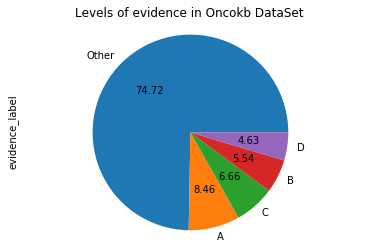

In [25]:
# Oncokb Figure 6a
import matplotlib.pyplot as plt

# Oncokb Only
oncokb_g2p_df = g2p_df[(g2p_df['source'].isin(['oncokb']))]
merge_by_chrom_ref = pd.merge(oncokb, oncokb_g2p_df, \
                         left_on=['Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2'], \
                         right_on=['feature_chromosome', 'feature_start', 'feature_ref', 'feature_alt']).fillna('Other')
merge_by_chrom_ref['evidence_label'].value_counts().plot(kind='pie', autopct='%.2f')
plt.axis('equal')

plt.title('Levels of evidence in Oncokb DataSet')
plt.savefig('oncokb_levels_of_evidence.png')

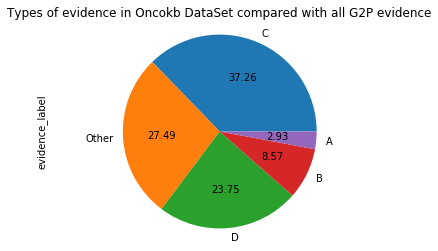

In [27]:
merge_by_chrom_ref = pd.merge(oncokb, g2p_df, how='left', \
                         left_on=['Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2'], \
                         right_on=['feature_chromosome', 'feature_start', 'feature_ref', 'feature_alt']).fillna('Other')


merge_by_chrom_ref['evidence_label'].value_counts().plot(kind='pie', autopct='%.2f')
plt.axis('equal')

plt.title('Types of evidence in Oncokb DataSet compared with all G2P evidence')
plt.savefig('oncokb_levels_of_evidence_g2p.png')

In [18]:
# Oncokb Figure 6b
from os import listdir

patient_cancer_types = pd.DataFrame(columns=['SAMPLE_ID', 'CANCER_TYPE'])
tumor_types = []
for file in listdir('../data/msk_impact_2017/case_lists/'):
    with open('../data/msk_impact_2017/case_lists/' + file) as f:
        lines = f.readlines()
    ls = lines[4].strip('case_list_ids: ').split('\t')
    for l in ls:
        ct = file.strip('case_list_').strip('.txt')
        d = {'SAMPLE_ID': l, 'CANCER_TYPE': ct}
        patient_cancer_types = patient_cancer_types.append(d, ignore_index=True)
        if ct not in tumor_types:
            tumor_types.append(ct)

patient_cancer_types.drop_duplicates()
# Are there patient listed for two cancer types?
print len(patient_cancer_types)
print len(patient_cancer_types.groupby('SAMPLE_ID'))
print tumor_types
# No. Good. 

10945
10945
['Adrenocortical_Carcinoma', 'Ampullary_Carcinoma', 'Anal_Cancer', 'Appendiceal_Cancer', 'Bladder_Cancer', 'Bone_Cancer', 'Breast_Cancer', 'Breast_Sarcoma', 'Cancer_of_Unknown_Primary', 'Cervical_Cancer', 'CNS_Cancer', 'Colorectal_Cancer', 'Embryonal_Tumor', 'Endometrial_Cancer', 'Esophagogastric_Cancer', 'Gastrointestinal_Neuroendocrine_Tumor', 'Gastrointestinal_Stromal_Tumor', 'Germ_Cell_Tumor', 'Gestational_Trophoblastic_Disease', 'Glioma', 'Head_and_Neck_Cancer', 'Hepatobiliary_Cancer', 'Histiocytosis', 'Hodgkin_Lymphoma', 'Leukemia', 'Mastocytosis', 'Melanoma', 'Mesothelioma', 'Miscellaneous_Brain_Tumor', 'Miscellaneous_Neuroepithelial_Tumor', 'Multiple_Myeloma', 'NA', 'Nerve_Sheath_Tumor', 'Non-Hodgkin_Lymphoma', 'Non-Small_Cell_Lung_Cancer', 'Ovarian_Cancer', 'Pancreatic_Cancer', 'Penile_Cancer', 'Pheochromocytoma', 'Pineal_Tumor', 'Prostate_Cancer', 'Renal_Cell_Carcinoma', 'Retinoblastoma', 'Salivary_Gland_Cancer', 'Sellar_Tumor', 'Sex_Cord_Stromal_Tumor', 'Skin_Can

In [19]:
oncokb_with_cancer = pd.merge(oncokb, patient_cancer_types, left_on=['SAMPLE_ID'], right_on=['SAMPLE_ID'])
oncokb_with_cancer.head()

,PATIENT_ID,SEX,VITAL_STATUS,SMOKING_HISTORY,OS_MONTHS,OS_STATUS,SAMPLE_ID,SAMPLE_COLLECTION_SOURCE,SPECIMEN_PRESERVATION_TYPE,SPECIMEN_TYPE,...,n_alt_count,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,RefSeq,Protein_position,Codons,Hotspot,CANCER_TYPE
0,P-0000004,Female,ALIVE,Unknown,0.0,LIVING,P-0000004-T01-IM3,Outside,FFPE,Biopsy,...,NaN,ENST00000375759.3:c.10981A>T,p.Ile3661Phe,p.I3661F,ENST00000375759,NM_015001.2,3661.0,Att/Ttt,0,Breast_Cancer
1,P-0000004,Female,ALIVE,Unknown,0.0,LIVING,P-0000004-T01-IM3,Outside,FFPE,Biopsy,...,NaN,ENST00000262189.6:c.2436G>A,p.Met812Ile,p.M812I,ENST00000262189,NM_170606.2,812.0,atG/atA,0,Breast_Cancer
2,P-0000004,Female,ALIVE,Unknown,0.0,LIVING,P-0000004-T01-IM3,Outside,FFPE,Biopsy,...,NaN,ENST00000349310.3:c.49G>A,p.Glu17Lys,p.E17K,ENST00000349310,NM_001014432.1,17.0,Gag/Aag,0,Breast_Cancer
3,P-0000004,Female,ALIVE,Unknown,0.0,LIVING,P-0000004-T01-IM3,Outside,FFPE,Biopsy,...,NaN,ENST00000269305.4:c.412_427delGCCAAGACCTGCCCTG,p.Ala138CysfsTer27,p.A138Cfs*27,ENST00000269305,NM_001126112.2,138.0,GCCAAGACCTGCCCTGtg/tg,0,Breast_Cancer
4,P-0000004,Female,ALIVE,Unknown,0.0,LIVING,P-0000004-T01-IM3,Outside,FFPE,Biopsy,...,NaN,ENST00000375759.3:c.10977T>A,p.Ile3659=,p.I3659=,ENST00000375759,NM_015001.2,3659.0,atT/atA,0,Breast_Cancer


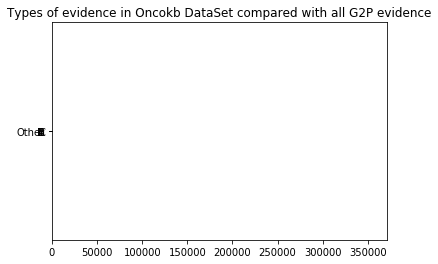

,PATIENT_ID,SEX,VITAL_STATUS,SMOKING_HISTORY,OS_MONTHS,OS_STATUS,SAMPLE_ID,SAMPLE_COLLECTION_SOURCE,SPECIMEN_PRESERVATION_TYPE,SPECIMEN_TYPE,...,feature_ref,feature_alt,feature_referenceName,feature_biomarker_type,feature_description,description,evidence_label,evidence_direction,evidence_url,oncogenic
43773,P-0000812,Male,ALIVE,Unknown,0.00,LIVING,P-0000812-T01-IM3,Outside,FFPE,Resection,...,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other
64350,P-0001070,Male,DECEASED,Prev/Curr Smoker,12.43,DECEASED,P-0001070-T01-IM3,Outside,FFPE,Resection,...,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other
64351,P-0001070,Male,DECEASED,Prev/Curr Smoker,12.43,DECEASED,P-0001070-T01-IM3,Outside,FFPE,Resection,...,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other
64352,P-0001070,Male,DECEASED,Prev/Curr Smoker,12.43,DECEASED,P-0001070-T01-IM3,Outside,FFPE,Resection,...,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other
102008,P-0001624,Male,ALIVE,Never,0.00,LIVING,P-0001624-T01-IM3,In-House,FFPE,Resection,...,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other
102009,P-0001624,Male,ALIVE,Never,0.00,LIVING,P-0001624-T01-IM3,In-House,FFPE,Resection,...,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other
102010,P-0001624,Male,ALIVE,Never,0.00,LIVING,P-0001624-T01-IM3,In-House,FFPE,Resection,...,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other
102011,P-0001624,Male,ALIVE,Never,0.00,LIVING,P-0001624-T01-IM3,In-House,FFPE,Resection,...,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other
102012,P-0001624,Male,ALIVE,Never,0.00,LIVING,P-0001624-T01-IM3,In-House,FFPE,Resection,...,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other
102013,P-0001624,Male,ALIVE,Never,0.00,LIVING,P-0001624-T01-IM3,In-House,FFPE,Resection,...,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other


In [20]:
merge_by_chrom_ref = pd.merge(oncokb_with_cancer, g2p_df, how='left', \
                         left_on=['Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2'], \
                         right_on=['feature_chromosome', 'feature_start', 'feature_ref', 'feature_alt']).fillna('Other')

merge_by_chrom_ref['evidence_label'].value_counts().plot.barh(stacked=True)
plt.axis('equal')

plt.title('Types of evidence in Oncokb DataSet compared with all G2P evidence')
plt.show()

merge_by_chrom_ref[merge_by_chrom_ref['CANCER_TYPE'].isin(['Adrenocortical_Carcinoma'])].head(10)

In [21]:
%%opts Bars [title_format="Distribution of actionability by tumor type" xrotation=90, height=500 width=800]
%%opts Bars (color=Cycle('Spectral'))
%%opts Bars [stack_index='evidence_label']

nt = pd.DataFrame(columns=['cancer_type', 'evidence_label', 'percentage'])
for tt in tumor_types:
    df = merge_by_chrom_ref[merge_by_chrom_ref['CANCER_TYPE'].isin([tt])]
    for e in evidence_levels:
        p = len(df[df['evidence_label'].isin([e])])/len(df)*100
        nt = nt.append({'cancer_type': tt, 'evidence_label': e, 'percentage': p}, ignore_index=True)
nt = nt.sort_values(by=['percentage'])
hv.Bars(nt, kdims=['cancer_type', 'evidence_label'], vdims=['percentage'])

:Bars   [cancer_type,evidence_label]   (percentage)

In [22]:
nt = pd.DataFrame(columns=['cancer_type', 'evidence_label', 'percentage'])
for tt in tumor_types:
    df = merge_by_chrom_ref[merge_by_chrom_ref['CANCER_TYPE'].isin([tt])]
    for e in evidence_levels:
        p = len(df[df['evidence_label'].isin([e])])/len(df)*100
        nt = nt.append({'cancer_type': tt, 'evidence_label': e, 'percentage': p}, ignore_index=True)

nt.head()

,cancer_type,evidence_label,percentage
0,Adrenocortical_Carcinoma,A,0.000000
1,Adrenocortical_Carcinoma,B,1.534527
2,Adrenocortical_Carcinoma,C,20.204604
3,Adrenocortical_Carcinoma,D,5.370844
4,Ampullary_Carcinoma,A,7.374631
